In [57]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.colors import to_rgba
from matplotlib.cm import get_cmap
import numpy as np
import itertools

In [18]:
NUM_TRAINERS = 10

In [20]:
# define function to getfilepath depending on the log type
def getfilepath(log_type, id = None):
    if log_type == "trainer":
        return f"trainer/trainer{id}_logs.txt"
    elif log_type == "aggregator":
        return "aggregator/agg_logs.txt"
    else:
        raise ValueError("Invalid log type")

In [21]:
file_path = getfilepath("trainer", trainer_id)

In [22]:
def parse_trainer_log_file(file, id):
    timestamps = []
    tags = []
    source = []
    destination = []

    # Regex pattern to match lines with timestamps and tags
    pattern = r"time: (\d+\.\d+), tag: (\w+)"

    # Reading the file and extracting data
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                timestamps.append(match.group(1))
                tags.append(match.group(2))
                source.append(f"trainer{id}")
                destination.append("aggregator")

    # Creating a DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Tag': tags,
        'Source': source,
        'Destination': destination
    })

    return df

In [25]:
dflist = []
for trainer_id in range(1,NUM_TRAINERS+1):
    file_path = getfilepath("trainer", trainer_id)
    dflist.append(parse_trainer_log_file(file_path, trainer_id))

mydf = pd.concat(dflist, ignore_index=True)

In [27]:
# dump to csv
mydf.to_csv("trainer/trainer_logs.csv", index=False)

In [44]:
id_to_trainer_name = {'505f9fc483cf4df68a2409257b5fad7d3c580371':'trainer1',
'505f9fc483cf4df68a2409257b5fad7d3c580372': 'trainer2',
'505f9fc483cf4df68a2409257b5fad7d3c580373':'trainer3',
'505f9fc483cf4df68a2409257b5fad7d3c580374':'trainer4',
'505f9fc483cf4df68a2409257b5fad7d3c580375':'trainer5',
'505f9fc483cf4df68a2409257b5fad7d3c580376':'trainer6',
'505f9fc483cf4df68a2409257b5fad7d3c580377':'trainer7',
'505f9fc483cf4df68a2409257b5fad7d3c580378':'trainer8',
'505f9fc483cf4df68a2409257b5fad7d3c580379':'trainer9',
'505f9fc483cf4df68a2409257b5fad7d3c580380':'trainer10'}

In [45]:
file_path = getfilepath("aggregator")

In [46]:
def parse_agg_log_file(file):
    timestamps = []
    tags = []
    source = []
    destination = []

    # Regex pattern to match lines with timestamps and tags
    pattern = r"DEBUG.*?time: (\d+\.\d+), (\w+).*? (\w+)$"

    # Reading the file and extracting data
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                timestamps.append(match.group(1))
                tags.append(match.group(2))
                source.append("aggregator")
                destination.append(id_to_trainer_name[match.group(3)])

    # Creating a DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Tag': tags,
        'Source': source,
        'Destination': destination
    })

    return df

In [47]:
parse_agg_log_file(file_path).to_csv("aggregator/agg_logs.csv", index=False)

In [149]:
trainer_to_plot = 'trainer10'

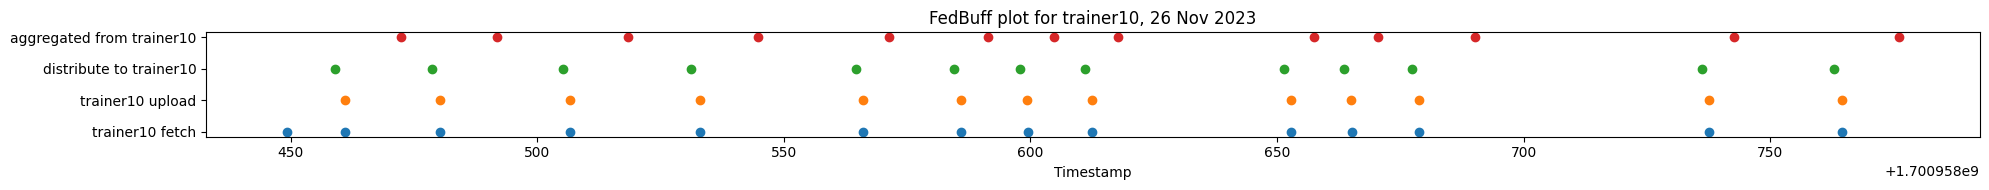

In [150]:
file_path = 'trainer/trainer_logs.csv'

# Read CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
agg_df = pd.read_csv('aggregator/agg_logs.csv')

# Plotting
fig, ax = plt.subplots(figsize=(20, 2))

combined_df = pd.concat([df,agg_df])

# Extract unique tags and assign colors
unique_tags = combined_df["Tag"].unique()
tag_colors = {tag: to_rgba(f'C{idx}') for idx, tag in enumerate(unique_tags)}

# Plot each source with the corresponding tag color
# for tag, color in tag_colors.items():
#     tag_df = df[df['Tag'] == tag]
for index, row in combined_df.iterrows():
    tag = row['Tag']
    if tag == "fetch":
        color = tag_colors["fetch"]
    elif tag == "upload":
        color = tag_colors["upload"]
    elif tag == "sending":
        color = tag_colors["sending"]
    else:
        color = tag_colors["received"]
    
    
    if row['Source'] == "aggregator":
        if row['Destination'] == trainer_to_plot:
            if str(tag) == 'sending':
                ax.plot(row['Timestamp'], 'distribute to '+row['Destination'], 'o', color=color, label=tag, linewidth=10)
            else:
                ax.plot(row['Timestamp'], 'aggregated from '+row['Destination'], 'o', color=color, label=tag, linewidth=10)
    else:
        if row['Source'] == trainer_to_plot:
            ax.plot(row['Timestamp'], row['Source']+' '+str(tag), 'o', color=color, label=tag, linewidth=10)

# yticks = list(trainer+' '+tag for trainer,tag in itertools.product(df['Source'].unique(),df['Tag'].unique())) + list(trainer+' '+tag for trainer,tag in itertools.product(agg_df['Destination'].unique(),agg_df['Tag'].unique()))
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)

ax.set_yticks([trainer_to_plot+' fetch', trainer_to_plot+' upload', 'distribute to '+trainer_to_plot, 'aggregated from '+trainer_to_plot]) 
ax.set_xlabel('Timestamp')
ax.set_title(f'FedBuff plot for {trainer_to_plot}, 26 Nov 2023')
# ax.legend()
plt.tight_layout()
plt.savefig(f'trainer/{trainer_to_plot}_plot_fedbuff_26nov.pdf', format='pdf', bbox_inches='tight')
plt.show()

combined_df[(combined_df['Source']==trainer_to_plot) | (combined_df['Destination']==trainer_to_plot)].sort_values(by=['Timestamp']).to_csv(f'trainer/{trainer_to_plot}_logs_fedbuff_26nov.csv', index=False)

In [124]:
# combined_df[(combined_df['Source']==trainer_to_plot) | (combined_df['Destination']==trainer_to_plot)].sort_values(by=['Timestamp']).to_csv('trainer/trainer10_logs.csv', index=False)

In [66]:
list(trainer+tag for trainer,tag in itertools.product(df['Source'].unique(),df['Tag'].unique()))

['trainer1fetch',
 'trainer1upload',
 'trainer2fetch',
 'trainer2upload',
 'trainer3fetch',
 'trainer3upload',
 'trainer4fetch',
 'trainer4upload',
 'trainer5fetch',
 'trainer5upload',
 'trainer6fetch',
 'trainer6upload',
 'trainer7fetch',
 'trainer7upload',
 'trainer8fetch',
 'trainer8upload',
 'trainer9fetch',
 'trainer9upload',
 'trainer10fetch',
 'trainer10upload']